# Co Founder Matching Using Machine Learning

In [1]:
# !pip install pandas
# !pip install nltk
# !pip install Faker
# !pip install scikit-learn
# !pip install matplotlib
# !pip install sentence-transformers

---

## Part 1: Data Collection

In [2]:
import pandas as pd
import re
import nltk
from faker import Faker

> Note: As the raw data is too large, only the processed datasets are present in the repository. 

> Download the raw data ('job_skills.csv' and 'linkedin_job_postings.csv') files from [1.3M LinkedIn Jobs and Skills (2024)](https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024/data).

In [3]:
# read the linkedin skills and job postings datasets

skills_df = pd.read_csv('./data/job_skills.csv')
postings_df = pd.read_csv('./data/linkedin_job_postings.csv')

In [4]:
skills_df.head()

,job_link,job_skills
0,https://www.linkedin.com/jobs/view/housekeeper...,"Building Custodial Services, Cleaning, Janitor..."
1,https://www.linkedin.com/jobs/view/assistant-g...,"Customer service, Restaurant management, Food ..."
2,https://www.linkedin.com/jobs/view/school-base...,"Applied Behavior Analysis (ABA), Data analysis..."
3,https://www.linkedin.com/jobs/view/electrical-...,"Electrical Engineering, Project Controls, Sche..."
4,https://www.linkedin.com/jobs/view/electrical-...,"Electrical Assembly, Point to point wiring, St..."


In [5]:
skills_df.shape

(1296381, 2)

In [6]:
postings_df.head()

,job_link,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type
0,https://www.linkedin.com/jobs/view/account-exe...,2024-01-21 07:12:29.00256+00,t,t,f,Account Executive - Dispensing (NorCal/Norther...,BD,"San Diego, CA",2024-01-15,Coronado,United States,Color Maker,Mid senior,Onsite
1,https://www.linkedin.com/jobs/view/registered-...,2024-01-21 07:39:58.88137+00,t,t,f,Registered Nurse - RN Care Manager,Trinity Health MI,"Norton Shores, MI",2024-01-14,Grand Haven,United States,Director Nursing Service,Mid senior,Onsite
2,https://www.linkedin.com/jobs/view/restaurant-...,2024-01-21 07:40:00.251126+00,t,t,f,RESTAURANT SUPERVISOR - THE FORKLIFT,Wasatch Adaptive Sports,"Sandy, UT",2024-01-14,Tooele,United States,Stand-In,Mid senior,Onsite
3,https://www.linkedin.com/jobs/view/independent...,2024-01-21 07:40:00.308133+00,t,t,f,Independent Real Estate Agent,Howard Hanna | Rand Realty,"Englewood Cliffs, NJ",2024-01-16,Pinehurst,United States,Real-Estate Clerk,Mid senior,Onsite
4,https://www.linkedin.com/jobs/view/group-unit-...,2024-01-19 09:45:09.215838+00,f,f,f,Group/Unit Supervisor (Systems Support Manager...,"IRS, Office of Chief Counsel","Chamblee, GA",2024-01-17,Gadsden,United States,Supervisor Travel-Information Center,Mid senior,Onsite


In [7]:
postings_df.shape

(1348454, 14)

In [8]:
# merge the linkedin skills and job postings datasets on the linkedin job link
# classify the linkedin job title based on the job skills

df_all = pd.merge(skills_df, postings_df, on='job_link')

df_all = df_all[['job_title', 'job_skills']]

In [9]:
# check and drop na rows

print('Number of NA rows:')
print(df_all.isna().sum())
df_all.dropna(axis=0, inplace=True, ignore_index=True)

Number of NA rows:
job_title        0
job_skills    2085
dtype: int64


In [10]:
# check and drop duplicated rows

print(f'Any duplicated rows? {df_all.duplicated().any()}')
df_all.drop_duplicates(keep='first', inplace=True, ignore_index=True)

Any duplicated rows? True


In [11]:
# the linkedin dataset is sampled for 4 job titles listed below.

job_titles = list(df_all['job_title'].value_counts()[:4].index)
print(f'Selected job titles:\n{job_titles}')

Selected job titles:
['LEAD SALES ASSOCIATE-FT', 'First Year Tax Professional', 'Shift Manager', 'Customer Service Representative']


In [12]:
# create 2 samples of the dataset:
# 1. list of skills required for a job. the classification model is trained and tested on this datset. use 4000 use 4000 samples from each job title for creating the model. total = 16000
# 2. assumed to be list of skills of potential cofounders coming from a cofounder database. the classification model is used to infer the class of these persons and present top "n" cofounders for a chosen job title. 1000 samples from each job title is be used to create the cofounder database. total = 4000


df = pd.DataFrame()
df_cofounders = pd.DataFrame()
for title in job_titles:
    df_title_all = df_all[df_all['job_title']==title]
    df_title = df_title_all.sample(4000, random_state=42)

    df_cofounders_title_all = df_title_all.loc[~df_title_all.index.isin(df_title.index)]
    df_cofounders_title = df_cofounders_title_all.sample(1000, random_state=42)

    df = pd.concat([df, df_title], ignore_index=True)
    df_cofounders = pd.concat([df_cofounders, df_cofounders_title], ignore_index=True)

df = df.sample(frac=1).reset_index(drop=True)
print(df.shape)

df_cofounders = df_cofounders.sample(frac=1).reset_index(drop=True)
y_cofounders = df_cofounders['job_title'] # save this for later
df_cofounders.drop('job_title', axis=1, inplace=True)
df_cofounders = df_cofounders.rename(columns={'job_skills': 'cofounder_skills'})
print(df_cofounders.shape)

(16000, 2)
(4000, 1)


In [13]:
# preprocessing the text

def preprocess_job_skills(text: str) -> str:
    # remove special chars and numbers
    text = re.sub("[^A-Za-z,]+", " ", text)
    
    # remove stopwords
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w.lower() in nltk.corpus.stopwords.words("english")]
    text = " ".join(tokens)
    text = text.lower().strip()    
    
    return text

In [14]:
df['job_skills'] = df['job_skills'].apply(lambda text: preprocess_job_skills(text))
df_cofounders['cofounder_skills'] = df_cofounders['cofounder_skills'].apply(lambda text: preprocess_job_skills(text))

In [15]:
# generate fake names

fake_names = []
fake = Faker()

for i in range(0, len(df_cofounders)):
    fake_names.append(fake.name())

# assign random names to minic data from a cofounder database
df_cofounders['full_name'] = fake_names

In [16]:
# save datasets

df.to_csv('./data/job_skills_processed.csv', index=False)
df_cofounders.to_csv('./data/cofounders.csv', index=False)

In [17]:
df.head()

,job_title,job_skills
0,LEAD SALES ASSOCIATE-FT,"customer service , cash register operation , s..."
1,Shift Manager,"leadership , food safety , internal communicat..."
2,LEAD SALES ASSOCIATE-FT,"customer service , cash register operation , m..."
3,First Year Tax Professional,"communication verbal virtual , income tax cour..."
4,Shift Manager,"food safety , internal communication , invento..."


In [18]:
df_cofounders.head()

,cofounder_skills,full_name
0,"customer service , cash register operation , m...",Linda Hill
1,"customer service , communication , teamwork , ...",Ana Chang
2,"tax interviews , tax returns preparation , bus...",Meredith Hernandez
3,"management , customer service , food safety , ...",Jessica Cortez
4,"customer service , cash handling , stocking , ...",Julia Cain


---

## Part 2: Building a Matching Algorithm

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import numpy as np

c:\All\Personal\BeeFound\Co-Founder-Matching-Using-Machine-Learning\.env\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [20]:
# encode the job skills using sentence-transformers/all-MiniLM-L6-v2

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
X = model.encode(df['job_skills'])

X.shape

(16000, 384)

In [21]:
# label encode the classes job_title

le = LabelEncoder()
y = le.fit_transform(df['job_title'])

y.shape

(16000,)

In [22]:
# split test and train data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f'Train size: {X_train.shape[0]}')
print(f'Test size: {X_test.shape[0]}')

Train size: 12000
Test size: 4000


In [23]:
# train random forest classifier

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

                                 precision    recall  f1-score   support

Customer Service Representative       0.96      1.00      0.98      1021
    First Year Tax Professional       1.00      0.99      1.00       957
        LEAD SALES ASSOCIATE-FT       1.00      0.99      1.00      1006
                  Shift Manager       1.00      0.98      0.99      1016

                       accuracy                           0.99      4000
                      macro avg       0.99      0.99      0.99      4000
                   weighted avg       0.99      0.99      0.99      4000



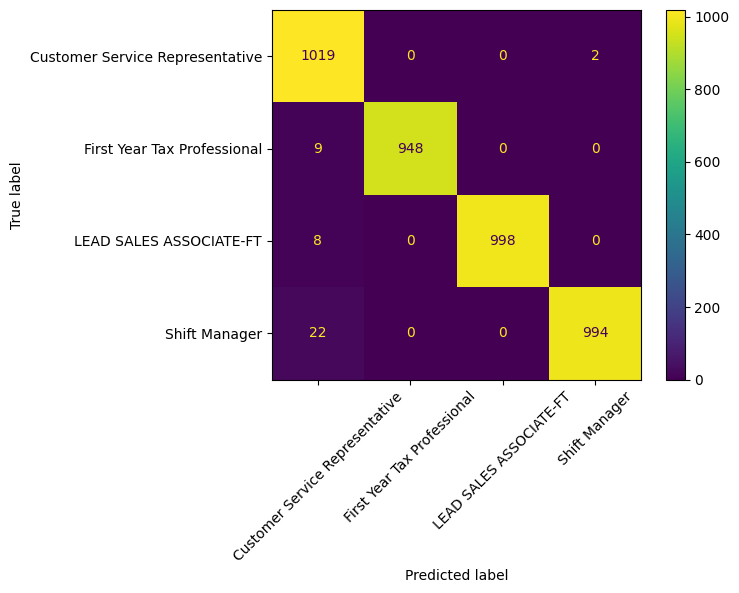

In [24]:
# display classification report and confusion matrix

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred) 

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = le.classes_)
cm_display.plot()
plt.xticks(rotation=45)
plt.show()

### Recommended cofounders

In [25]:
# get the cofounder database and use the model to infer its predicted class and predicted probability

X_cofounders = model.encode(df_cofounders['cofounder_skills'])

df_cofounders['pred'] = clf.predict(X_cofounders)
df_cofounders['pred_proba'] = np.apply_along_axis(max, 1, clf.predict_proba(X_cofounders))

In [26]:
# show top n cofounders

n = 10

In [27]:
# for each title, display top n cadidates as predicted by the model

for i, title in enumerate(le.classes_):
    cofounders = df_cofounders.loc[df_cofounders['pred']==i][['cofounder_skills', 'full_name', 'pred', 'pred_proba']]
    cofounders_top_n = cofounders.sort_values(by=['pred_proba'], ascending=False, ignore_index=True)[:n]
    print(f'The following people are selected for {title} position based on their skills:\n')
    print(cofounders_top_n[['full_name', 'cofounder_skills', 'pred_proba']])
    print('-'*30)

The following people are selected for Customer Service Representative position based on their skills:

         full_name                                   cofounder_skills  \
0       Larry Hill  customer service , sales , communication , tea...   
1    Andres Werner  customer service , cashiering , sales , commun...   
2    Shelly Harris  customer service , communication , problem sol...   
3     Maria Lawson  customer service , call center , ms word , exc...   
4  Elizabeth Smith  customer service , cashiering , sales , commun...   
5       Dawn Perez  customer service , retail experience , sales a...   
6   Chelsea Parker  customer service , retail , cashiering , sales...   
7    Stacy Stewart  customer service , sales , communication , tea...   
8      John Miller  customer service , communication , teamwork , ...   
9       Daniel Cox  customer service , retail , cashiering , sales...   

   pred_proba  
0         1.0  
1         1.0  
2         1.0  
3         1.0  
4         1.0

### Evaluation

                                 precision    recall  f1-score   support

Customer Service Representative       0.97      1.00      0.99      1000
    First Year Tax Professional       1.00      0.99      1.00      1000
        LEAD SALES ASSOCIATE-FT       1.00      1.00      1.00      1000
                  Shift Manager       1.00      0.98      0.99      1000

                       accuracy                           0.99      4000
                      macro avg       0.99      0.99      0.99      4000
                   weighted avg       0.99      0.99      0.99      4000



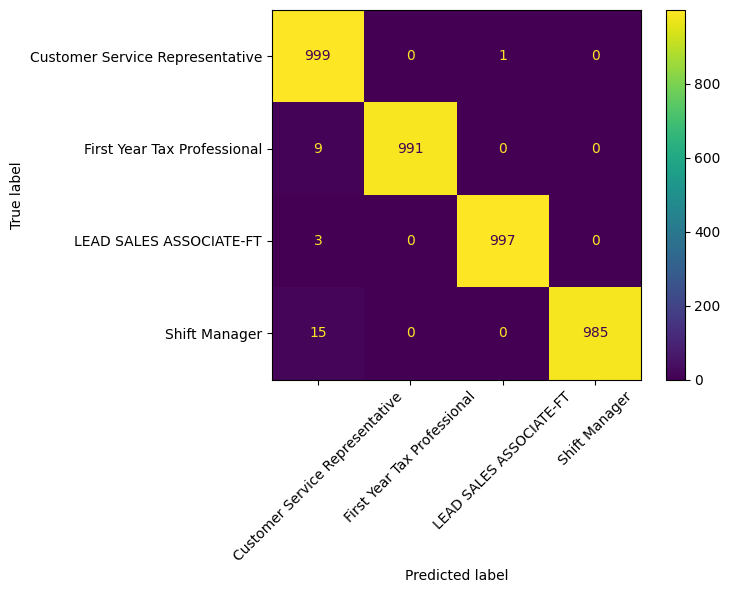

In [28]:
# display classification report and confusion matrix for eval(cofounders) data

y_pred_cofounders = clf.predict(X_cofounders)

y_cofounders = le.transform(y_cofounders)

print(classification_report(y_cofounders, y_pred_cofounders, target_names=le.classes_))

cm = confusion_matrix(y_cofounders, y_pred_cofounders) 

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = le.classes_)
cm_display.plot()
plt.xticks(rotation=45)
plt.show()

---